In [1]:
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt

from pathlib import Path

import pickle, gzip, torch
import torch.distributions as dist
import numpy as np

from rnn_utils import load_rnn_model, load_smiles_from_list, rnn_start_token_vector
from smiles_char_dict import SmilesCharDictionary

In [2]:
test_smiles, test_prop = np.load("../../data/QM9/QM9_clean_smi_test_smile.npz",allow_pickle=True).values()
#prior = pickle.load(gzip.open('../data/prior.pkl.gz'))
train_smiles, train_prop = np.load("../../data/QM9/QM9_clean_smi_train_smile.npz",allow_pickle=True).values()

model_path = '../lstm/output/QM9/2020_1_17/model_79_0.167.pt'
model_def = Path(model_path).with_suffix('.json')

# get two RNNs: one trained, one random
trained_model = load_rnn_model(model_def, model_path, device='cpu', copy_to_cpu=True)
random_model = load_rnn_model(model_def, model_path, device='cpu', copy_to_cpu=True)
random_model.init_weights()


In [3]:
trained_model.input_size

47

# Define a function to sample from the RNN-based model

In [4]:
def sample_from_model(model, y, N_samples, max_len=100, greedy=False):
    """ Draw samples from the model, and return three things:
    
        (1) the sampled values
        (2) the probability corresponding to each of those sampled values
        (3) the probability distributions used for sampling at each t = 1,…,T
        
        If the argument `greedy=True`, then instead of sampling at each
        step it deterministically draws the maximum of the distribution.
    """
    device = y.device
    spot_check = True
    model.eval()
    
    # hold the output here
    actions = torch.zeros((N_samples, max_len), dtype=torch.long).to(device)
    sampled_probs = torch.zeros((N_samples, max_len)).to(device)
    sampling_dists = torch.zeros((N_samples, max_len, model.input_size)).to(device)
    #sampling_dists = np.empty((batch_size, max_len), dtype=object)

    # initialization for LSTM sampling
    hidden = model.init_hidden(N_samples, device)
    inp = rnn_start_token_vector(N_samples, device)
    
    # run character-by-character...
    for char in range(max_len):
        # one step forward
        output, hidden = model(inp, y.expand(N_samples, -1), hidden)

        prob = torch.softmax(output, dim=2)
        if greedy:
            # alternative, if we want to take the max instead of sampling
            action = output.argmax(dim=2)             
        else:
            d = dist.Categorical(probs=prob)
            action = d.sample()
            
        # store results
        actions[:,char] = action.squeeze(1)
        sampled_probs[:,char] = prob.squeeze(1)[torch.arange(len(action)),action.squeeze(1)]
        sampling_dists[:,char] = prob.squeeze(1)

        # double-check there is no bug
        if spot_check:
            j = np.random.randint(N_samples)
            assert sampling_dists[j,char,action[j]] == sampled_probs[j,char]

        # input into next timestep of LSTM
        inp = action
      

    return actions, sampled_probs, sampling_dists


# Different ways of approximating the entropy

The entropy of $p_\theta(x | y) = \prod_{t=1}^T p_\theta(x_t | x_{1:t-1}, y)$ is

$$H[p_\theta(x|y)] = - E_{p_\theta(x | y)}[\log p_\theta(x | y)] = -E_{p_\theta(x | y)}\left[\sum_{t=1}^T \log p_\theta(x_t | x_{1:t-1}, y)\right].$$

The naive monte carlo estimator involves sampling trajectories $x$, given $y$, and then evaluating the log probabilities.

$$\hat H_{MC} = - \frac{1}{S} \sum_{s=1}^S \sum_{t=1}^T \log p_\theta(x_t^s | x^s_{1:t-1}, y) $$

for $x_t^s \sim p_\theta(x | y)$.

The alternative way of approximating the entropy involves decomposing this into a sequence of other entropies. In this way, we have

$$H[p_\theta(x|y)] = H[p_\theta(x_1 | y)] + \sum_{t=2}^T E_{p_\theta(x_{1:t-1}|y)}\left[H[p_\theta(x_t | x_{1:t-1}, y)]\right].$$

Since the entropy for each individual $x_t$ is cheap enough to compute directly in closed form, we can do so and just use sampling in order to generate the values we condition on at each step.
This probably should be lower variance.
Also, in the case when $x_t$ are sampled from continuous distributions, this also would be easy to directly reparameterize and use to take gradients.

Let's try this for a few different number of samples, and see what the distribution of the estimators look like.
We'll call the first one **Estimator A** and the second one **Estimator B**.

In [5]:
# pick a random properties value
index = np.random.randint(len(test_smiles))
print(index)
#y = prior.transform(properties[index:index+1])
def normalize(prop):
    train_smiles, train_prop = np.load("../../data/QM9/QM9_clean_smi_train_smile.npz",allow_pickle=True).values()
    mean = np.mean(train_prop, axis = 0)
    std = np.std(train_prop, axis = 0)
    return (prop - mean) / std

y = normalize(test_prop)[index:index+1]
print("Our property vector today:\n", y.squeeze())

1569
Our property vector today:
 [-0.845776   -0.45506914 -0.12361375 -0.50290503 -0.80384633  0.95706758
  0.05098709 -0.11251635  1.04039543]


In [9]:
%%time

with torch.no_grad():
    samples, probs, dists = sample_from_model(trained_model, torch.FloatTensor(y), 15)

CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 251 ms


In [12]:
dists.shape

torch.Size([15, 100, 47])

In [ ]:
dists[1,20, 1]

In [13]:
def test_mc_estimators(model, y, N_samples, N_trials=15):
#     mc_est = np.array([entropy_simple_mc(model, y, N_samples) for _ in range(N_trials)])
    with torch.no_grad():
        est_A = np.zeros((N_trials,))
        est_B = np.zeros((N_trials,))
        for i in range(N_trials):
            samples, probs, dists = sample_from_model(model, torch.FloatTensor(y), N_samples)
            est_A[i] = -probs.log().sum(-1).mean()
            est_B[i] = -((dists+1e-45).log()*dists).sum(-1).sum(-1).mean()
            
    dist_A = dist.Normal(est_A.mean(), est_A.std())
    dist_B = dist.Normal(est_B.mean(), est_B.std())

    # plot them both
    plt.subplot(121)
    plt.hist(est_A, bins=20);
    plt.title("%d samples, estimator A" % N_samples)
    plt.xlabel("mean = %0.3f, std = %0.3f" % (dist_A.loc.item(), dist_A.scale.item()))

    plt.subplot(122)
    plt.hist(est_B, bins=20);
    plt.title("%d samples, estimator B" % N_samples)
    plt.xlabel("mean = %0.3f, std = %0.3f" % (dist_B.loc.item(), dist_B.scale.item()))


    return est_A, est_B, dist_A, dist_B

CPU times: user 1min 22s, sys: 719 ms, total: 1min 22s
Wall time: 14.7 s


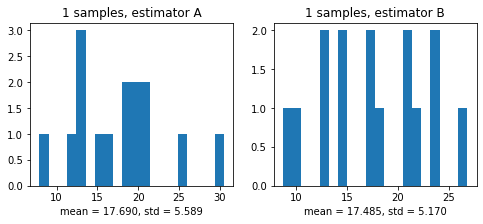

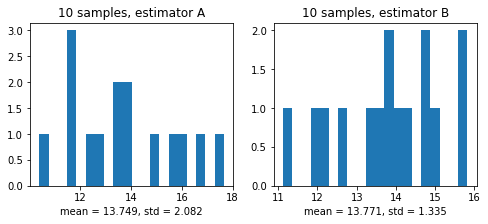

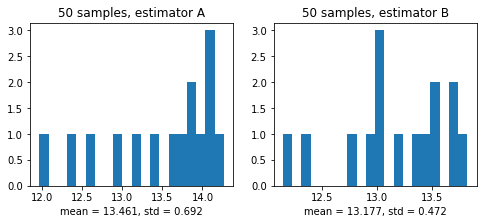

In [14]:
%%time
plt.figure(figsize=(8,3))
tmp = test_mc_estimators(trained_model, y, 1, N_trials=15);
trained_model_one_sample = tmp[-1]

plt.figure(figsize=(8,3))
tmp = test_mc_estimators(trained_model, y, 10, N_trials=15);

plt.figure(figsize=(8,3))
tmp = test_mc_estimators(trained_model, y, 50, N_trials=15);
plt.savefig('entropy.jpg')

### This last, best estimator we can treat as our "ground truth" for purposes of the next section.

In [21]:
trained_model_gt = tmp[-1]
trained_model_gt.log_prob(1)

tensor(-333.6640)

In [22]:
tmp[-1]

Normal(loc: 13.177141189575195, scale: 0.47150295972824097)

### Let's also run this experiment again, but on a completely random (untrained) model.

In [ ]:
plt.figure(figsize=(8,3))
tmp = test_mc_estimators(random_model, y, 1, N_trials=15);
random_model_one_sample = tmp[-1]

plt.figure(figsize=(8,3))
tmp = test_mc_estimators(random_model, y, 10, N_trials=15);

plt.figure(figsize=(8,3))
tmp = test_mc_estimators(random_model, y, 50, N_trials=15);

random_model_gt = tmp[-1]
random_model_gt

# Other approximations which allow gradient computation

Possibilities:

1. Deterministic greedy decoding by using the max, instead of sampling
2. Straight-through estimator, taking a mean of the embeddings


## Greedy decoding

In [ ]:
_, probs, dists = sample_from_model(trained_model, torch.FloatTensor(y), 1, greedy=True)
est_A_greedy = -probs.log().sum()
est_B_greedy = -((dists + 1e-45).log()*dists).sum(-1).sum()

domain = torch.linspace(trained_model_one_sample.loc.item() - 5*trained_model_one_sample.scale.item(),
                        trained_model_one_sample.loc.item() + 5*trained_model_one_sample.scale.item(),
                        200)

plt.title("test on trained model")
plt.plot(domain, trained_model_gt.log_prob(domain).exp());
plt.plot(domain, trained_model_one_sample.log_prob(domain).exp());
height = plt.ylim()[1] * 0.25
plt.plot([est_A_greedy, est_A_greedy], [0.0, height], '-')
plt.plot([est_B_greedy, est_B_greedy], [0.0, height], '-')
plt.legend(['MC 50 samples', 'MC one sample', 'greedy A', 'greedy B']);
plt.xlabel("entropy estimate");

trained_greedy = est_B_greedy # save for later

In [ ]:
_, probs, dists = sample_from_model(random_model, torch.FloatTensor(y), 1, greedy=True)
est_A_greedy = -probs.log().sum()
est_B_greedy = -(dists.log()*dists).sum(-1).sum()

domain = torch.linspace(random_model_one_sample.loc.item() - 5*random_model_one_sample.scale.item(),
                        random_model_one_sample.loc.item() + 5*random_model_one_sample.scale.item(),
                        200)

plt.title("test on random model")
plt.plot(domain, random_model_gt.log_prob(domain).exp());
plt.plot(domain, random_model_one_sample.log_prob(domain).exp());
height = plt.ylim()[1] * 0.25
plt.plot([est_A_greedy, est_A_greedy], [0.0, height], '-')
plt.plot([est_B_greedy, est_B_greedy], [0.0, height], '-')
plt.legend(['MC 50 samples', 'MC one sample', 'greedy A', 'greedy B']);
plt.xlabel("entropy estimate");

random_greedy = est_B_greedy # save for later

#### Estimator A is pretty bad in this context. Let's look at B alone…

In [ ]:

plt.title("test on random model, est B only")
plt.plot(domain, random_model_gt.log_prob(domain).exp());
plt.plot(domain, random_model_one_sample.log_prob(domain).exp());
height = plt.ylim()[1] * 0.25
plt.plot([est_B_greedy, est_B_greedy], [0.0, height], '-')
plt.legend(['MC 50 samples', 'MC one sample', 'greedy B']);
plt.xlabel("entropy estimate");

That's probably fine, or at least good-enough to use as a regularizer during early stages of training (i.e. when the network is random-ish).

Greedy decoding for the values we condition on seems to work reasonably well for approximating the entropy.
It might be slow-ish though, since it does require unrolling the RNN.

## Straight-through estimator

For the straight-through estimator, instead of evaluating the RNN on the embedding of a single input, we compute the mean of the embeddings under the distribution. This is the "wrong" thing to do, but has precedent.

In [ ]:
# quick check: how to use the embedding layers directly

inp = torch.nn.functional.one_hot(rnn_start_token_vector(10, 'cpu'), trained_model.input_size).float()
v1 = inp @ trained_model.encoder.weight
v2 = trained_model.encoder(rnn_start_token_vector(10, 'cpu'))
assert (v1 == v2).float().mean().item() == 1.0

In [ ]:
def straight_through_estimate(model, y, max_len=100):
    device = y.device
    model.eval()
    
    # hold the output here
    H_t = torch.zeros((max_len, )).to(device)

    # initialization for LSTM sampling
    hidden = model.init_hidden(1, device)
    inp = torch.nn.functional.one_hot(rnn_start_token_vector(1, device), model.input_size).float()
    
    # run character-by-character...
    for char in range(max_len):
        # one step forward
        # this requires reproducing the `forward` function of the model itself
        embeds = inp @ model.encoder.weight
        output, hidden = model.rnn(torch.cat((embeds, y.expand(1, -1).unsqueeze(1).expand(-1,1,-1)), -1), hidden)
        output = model.decoder(output)
        prob = torch.softmax(output, dim=2)
        H_t[char] = -(prob.log() * prob).sum()
        inp = prob # send probabilities instead of selecting next action

    return H_t

In [ ]:
with torch.no_grad():
    H_est_s_trained = straight_through_estimate(trained_model, torch.FloatTensor(y)).sum()
    H_est_s_random = straight_through_estimate(random_model, torch.FloatTensor(y)).sum()


In [ ]:
domain = torch.linspace(trained_model_one_sample.loc.item() - 5*trained_model_one_sample.scale.item(),
                        trained_model_one_sample.loc.item() + 5*trained_model_one_sample.scale.item(),
                        200)

plt.title("test on trained model")
plt.plot(domain, trained_model_gt.log_prob(domain).exp());
plt.plot(domain, trained_model_one_sample.log_prob(domain).exp());
height = plt.ylim()[1] * 0.25
plt.plot([trained_greedy, trained_greedy], [0.0, height], '-')
plt.plot([H_est_s_trained, H_est_s_trained], [0.0, height], '-')
plt.legend(['MC 50 samples', 'MC one sample', 'greedy', 'straight-through']);
plt.xlabel("entropy estimate");

In [ ]:
trained_model_one_sample.loc.item() 

In [ ]:
domain = torch.linspace(random_model_one_sample.loc.item() - 5*random_model_one_sample.scale.item(),
                        random_model_one_sample.loc.item() + 5*random_model_one_sample.scale.item(),
                        200)

plt.title("test on random model")
plt.plot(domain, random_model_gt.log_prob(domain).exp());derivative
plt.plot(domain, random_model_one_sample.log_prob(domain).exp())
height = plt.ylim()[1] * 0.25
plt.plot([random_greedy, random_greedy], [0.0, height], '-')
plt.plot([H_est_s_random, H_est_s_random], [0.0, height], '-')
plt.legend(['MC 50 samples', 'MC one sample', 'greedy', 'straight-through']);
plt.xlabel("entropy estimate");

## Looks like the straight-through estimator is better on the random model, and the greedy estimator is better on the fully trained model!

In [ ]:
def greedy_entropy_est(model, y, max_len=100):
    """ Quick re-implementation of greedy entropy estimation """
    H_est = 0.0
    device = y.device

    # initialization for LSTM sampling
    hidden = model.init_hidden(1, device)
    inp = rnn_start_token_vector(1, device)
    
    # run character-by-character...
    for char in range(max_len):
        # one step forward
        output, hidden = model(inp, y.expand(1, -1), hidden)
        action = output.argmax(dim=2)

        log_prob = output - torch.logsumexp(output, dim=-1, keepdim=True)
        H_est += -(log_prob.exp() * log_prob).sum()
        inp = action

    return H_est


print(trained_greedy.item(), greedy_entropy_est(trained_model, torch.FloatTensor(y)))
print(random_greedy.item(), greedy_entropy_est(random_model, torch.FloatTensor(y)))

In [ ]:
max_len